# Best CNN-LSTM classifier

This model created from the hyper parameters obtained from hyper parameter tuning with SKlearn.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score as score
from tensorflow.python.client import device_lib


# Visiualization imports, Netron and tensorboard:
import netron
from datetime import datetime
from packaging import version
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import tensorboard
tensorboard.__version__


TensorFlow version:  2.3.1


'2.3.0'

In [2]:
# Try to get reproducable results
from numpy.random import seed
seed(85)
from tensorflow.random import set_seed
set_seed(75)

#### Set hyperparameters

In [3]:
# output directory name:
output_dir = 'output/CNN-LSTM-Final/'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/backpack/'
input_file_name = 'backpack-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency

n_lstm_2 = 128
n_lstm_1 = 128
n_dense_2= 384
n_dense_1= 384
n_conv_3= 512
n_conv_2= 512
n_conv_1= 768
maxpooling_pool_size= 2
k_conv_3= 2
k_conv_2= 2
k_conv_1= 2
dropout_2= 0.2
dropout_1= 0.2
drop_lstm_2 = 0.02
drop_lstm_1 = 0.1
avepooling_pool_size= 2
activation_dense = LeakyReLU()
activation_conv = 'relu'



# training:
epochs = 120
batch_size = 256


#### Load data

For this notebook we use only the **acceleration** data prepared in the DataPrep-Deep notebook.

In [4]:
# import the data
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [5]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
print(f'The are {len(class_list)} classes: {class_list}')

The are 6 classes: ['Lying' 'Running 3 METs' 'Running 5 METs' 'Running 7 METs'
 'Self Pace walk' 'Sitting']


#### Convert to categorical values

In [6]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
input_shape = list(accel_array.shape)


#### Design neural network architecture

In [7]:
# The best conv-lstm model!
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))

# LSTM layers
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, return_sequences=True)) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, return_sequences=True))

# Dense layers
model.add(Flatten())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 89, 768)           5376      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 768)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 43, 512)           786944    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 512)           524800    
_________________________________________________________________
lstm (LSTM)                  (None, 20, 128)           328192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           1

### Splitting and shuffeling the data

In [9]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Prepare to save each epoch
The weights and a log for tensorboard are saved. Later we load back the best model

In [10]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

# Define the Keras TensorBoard callback.
logdir=  "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


#### Create a folder to save each epoch of training

In [11]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [12]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((58290, 90, 3), (58290, 6), (6477, 90, 3), (6477, 6))

#### Train!

In [13]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint, tensorboard_callback])

Epoch 1/120
  1/228 [..............................] - ETA: 0s - loss: 1.7919 - accuracy: 0.1992WARNING:tensorflow:From C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
228/228 [==============================] - 18s 78ms/step - loss: 0.8156 - accuracy: 0.7009 - val_loss: 0.6196 - val_accuracy: 0.7751
Epoch 2/120
228/228 [==============================] - 16s 71ms/step - loss: 0.5481 - accuracy: 0.8114 - val_loss: 0.4758 - val_accuracy: 0.8453
Epoch 3/120
228/228 [==============================] - 16s 71ms/step - loss: 0.4285 - accuracy: 0.8596 - val_loss: 0.3884 - val_accuracy: 0.8774
Epoch 4/120
228/228 [==============================] - 16s 72ms/step - loss: 0.3651 - accuracy: 0.8842 - val_loss: 0.4022 - val_accuracy: 0.8655
Epoch 5/120
228/

228/228 [==============================] - 17s 73ms/step - loss: 0.0772 - accuracy: 0.9728 - val_loss: 0.3474 - val_accuracy: 0.9281
Epoch 53/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0725 - accuracy: 0.9749 - val_loss: 0.3990 - val_accuracy: 0.9293
Epoch 54/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0745 - accuracy: 0.9742 - val_loss: 0.3540 - val_accuracy: 0.9276
Epoch 55/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0758 - accuracy: 0.9735 - val_loss: 0.3704 - val_accuracy: 0.9304
Epoch 56/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0729 - accuracy: 0.9745 - val_loss: 0.3970 - val_accuracy: 0.9282
Epoch 57/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0718 - accuracy: 0.9746 - val_loss: 0.3998 - val_accuracy: 0.9302
Epoch 58/120
228/228 [==============================] - 17s 73ms/step - loss: 0.0702 - accuracy: 0.9757 - val_loss: 0.4037 - val_accuracy

228/228 [==============================] - 16s 72ms/step - loss: 0.0426 - accuracy: 0.9849 - val_loss: 0.5566 - val_accuracy: 0.9330
Epoch 109/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0424 - accuracy: 0.9847 - val_loss: 0.4931 - val_accuracy: 0.9338
Epoch 110/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0475 - accuracy: 0.9836 - val_loss: 0.5543 - val_accuracy: 0.9348
Epoch 111/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0446 - accuracy: 0.9841 - val_loss: 0.5012 - val_accuracy: 0.9319
Epoch 112/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0459 - accuracy: 0.9835 - val_loss: 0.5594 - val_accuracy: 0.9324
Epoch 113/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0460 - accuracy: 0.9839 - val_loss: 0.4944 - val_accuracy: 0.9370
Epoch 114/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0410 - accuracy: 0.9855 - val_loss: 0.5355 - val_ac

#### Load the best epoch's weight

In [28]:
model.load_weights(output_dir+"/weights.113.hdf5") #93.70

## Evaluate

Make predictions and check the results

In [29]:
y_hat = model.predict(x_valid)

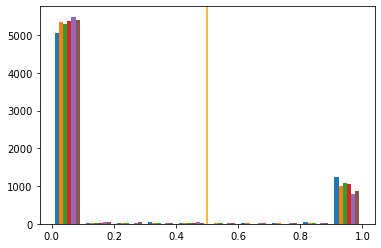

In [30]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

#### Histogram of probabilities for each class
If most probabilities are around either zero or one, it means the model was confidant in classification

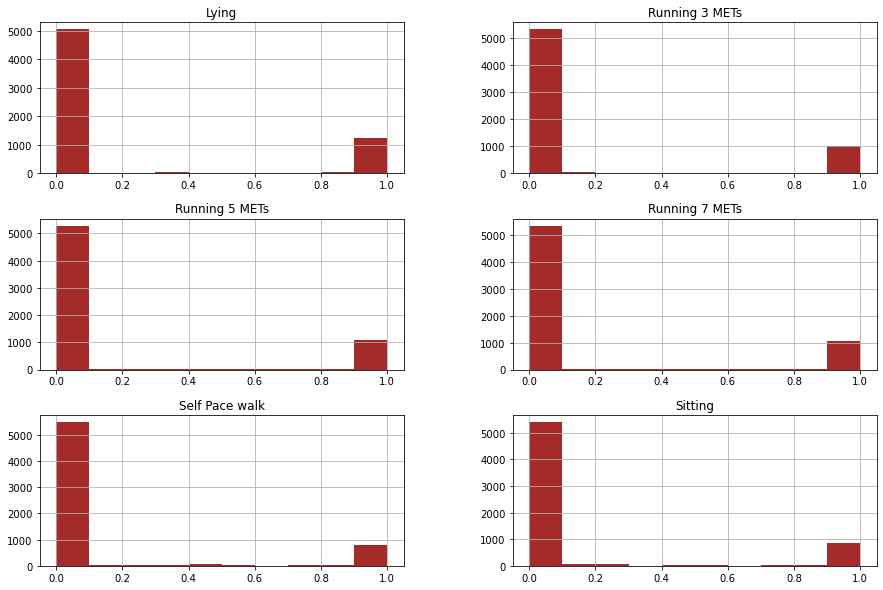

In [31]:
df = pd.DataFrame(y_hat, columns=class_list)
_ = df.hist(figsize=(15,10), color='brown')

In [32]:
# Calculate ROC and Accuracy
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100

In [33]:
print("The model accuracy is: {:0.2f}".format(acc))
print("The area under ROC curve is: {:0.2f}".format(pct_auc))

The model accuracy is: 93.31
The area under ROC curve is: 98.95


In [34]:
# Convert the predicted outcomes to categorical variable to compare with validation data, just for checking

float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:7].round(3))

In [35]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [36]:
ydf.head()

,y_hat,y
0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,"[0.47, 0.0, 0.0, 0.53, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [37]:
# convert probability to class
y_pred_class = np.argmax(y_hat, axis=1)
y_class = np.argmax(y_valid, axis = 1)

### plot confusion matrix
First use seaborn, then a custom stript.

In [38]:
# Create confucion matrix:
cf_matrix = confusion_matrix(y_class, y_pred_class, labels=range(len(class_list)))


# the classes are not in order, for example 'sitting' is not following 'lying'. Sort them:

confusion_matrix_df = pd.DataFrame(cf_matrix, index=class_list, columns=class_list)
confusion_matrix_df = confusion_matrix_df[['Lying','Sitting', 'Self Pace walk',\
                                           'Running 3 METs','Running 5 METs', 'Running 7 METs']]
confusion_matrix_df = confusion_matrix_df.reindex(['Lying', 'Sitting', 'Self Pace walk',\
                                                   'Running 3 METs','Running 5 METs', 'Running 7 METs'])

<AxesSubplot:>

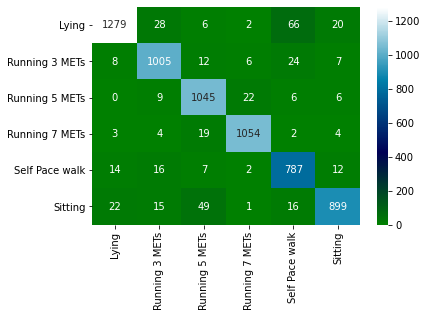

In [39]:
sns.heatmap(cf_matrix, annot=True, fmt = '1', xticklabels=class_list, yticklabels=class_list, cmap='ocean')
# cf_matrix

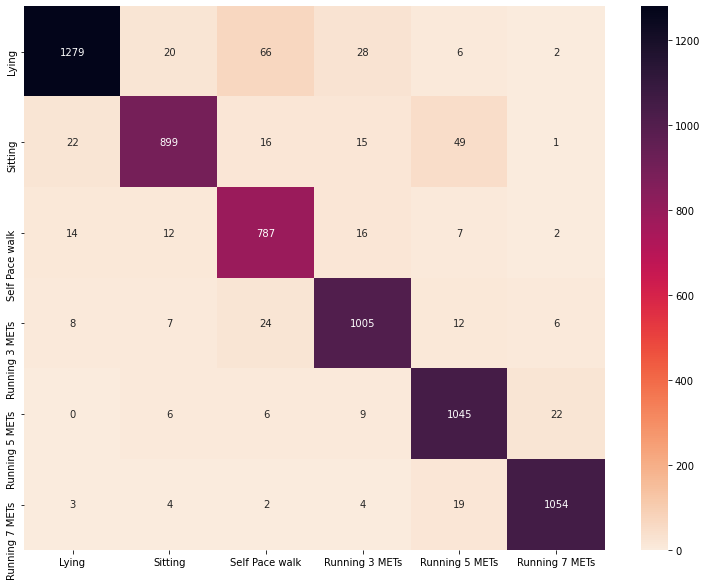

In [40]:
plt.figure(figsize = (13,10))

_ = sns.heatmap(confusion_matrix_df, annot=True, fmt = '1', cmap='rocket_r') # try cmap='rocket', 'PuBuGn', 'magma'


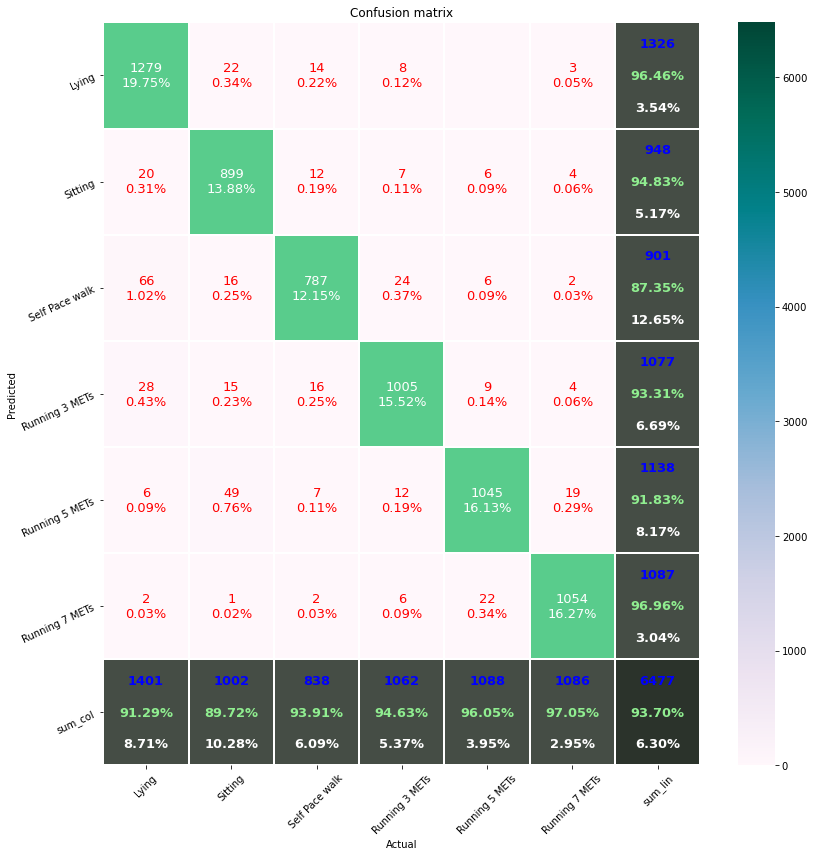

In [41]:
import prettyconfusion as pf
pf.pretty_plot_confusion_matrix(confusion_matrix_df,cmap='PuBuGn', cbar='oranges'
                                ,fz = 13, lw=1, figsize=[12,12])

## Visualize performance metrics and the model's structure

In [42]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [43]:
# Clear any logs from previous runs if you don't want to see it in tensorflow

In [44]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 10432.

In [45]:
# All stored weights have the same structure. Load one of them to netron and save the image 
netron.start(file=output_dir+"/weights.99.hdf5")

Serving 'output/CNN-LSTM-Final//weights.99.hdf5' at http://localhost:8080
